<a href="https://colab.research.google.com/github/amkayhani/FAIDM/blob/main/Ensemble_Learning_Structured_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Ensemble Learning on Structured Data (Bagging, Boosting, Stacking)

This notebook explains **ensemble learning** with **very simple language** and lots of hands-on examples.

We will focus on **structured (tabular) data**: rows are examples, columns are features.

## What you will learn
- What an **ensemble** is (many models working together)
- **Bagging** (build many models in parallel and average them)
- **Boosting** (build models one after another, each one fixes earlier mistakes)
- **Stacking** (train a “meta-model” to combine different models)
- How to evaluate models in a clean way (train/test split, cross-validation)
- A small exercise for **each** method

---

> Tip: This notebook is designed for Google Colab, but it works in any Jupyter notebook.


In [1]:

# If you run on Colab, these libraries are usually already installed.
# If not, you can install them with pip, e.g.:
# !pip install scikit-learn pandas numpy matplotlib

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Base models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Bagging
from sklearn.ensemble import BaggingClassifier

# Boosting
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

# Stacking (and a useful baseline: voting)
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt

import sklearn
print("scikit-learn version:", sklearn.__version__)


scikit-learn version: 1.6.1



## 1) Create a structured (tabular) dataset

To keep this notebook self-contained, we will **generate** a dataset.

We will create:
- several **numeric** features
- a couple of **categorical** features (strings like `"North"` / `"South"`)
- a binary target `y` (0 or 1)

We will also inject a few missing values, because real data often has them.


In [2]:

from sklearn.datasets import make_classification

rng = np.random.default_rng(42)

# Make numeric features
X_num, y = make_classification(
    n_samples=4000,
    n_features=10,
    n_informative=6,
    n_redundant=2,
    n_clusters_per_class=2,
    class_sep=1.2,
    weights=[0.55, 0.45],
    random_state=42,
)

num_cols = [f"num_{i}" for i in range(X_num.shape[1])]
df = pd.DataFrame(X_num, columns=num_cols)

# Add a categorical column made from a numeric feature (binning)
df["age_group"] = pd.cut(
    df["num_0"],
    bins=[-np.inf, -0.5, 0.5, np.inf],
    labels=["young", "middle", "older"],
).astype("object")

# Add another categorical column (random "region")
df["region"] = rng.choice(["North", "South", "East", "West"], size=len(df), replace=True)

# Inject missing values (about 3% in some columns)
for col in ["num_2", "num_7", "age_group"]:
    mask = rng.random(len(df)) < 0.03
    df.loc[mask, col] = np.nan

df.head()


,num_0,num_1,num_2,num_3,num_4,num_5,num_6,num_7,num_8,num_9,age_group,region
0,3.148007,1.284440,-0.945299,-2.165500,-2.581355,-0.722206,-1.232158,0.599102,-1.050815,-0.461973,older,North
1,1.877039,0.096491,-2.522626,-3.977679,0.037696,-0.318228,-0.330035,-0.701090,1.410267,-2.310849,older,West
2,0.246699,3.666092,-1.809732,-1.619499,0.498560,1.735709,-1.230797,0.818287,2.094243,0.128823,middle,East
3,1.079769,4.436813,-3.067674,-3.935200,1.158438,2.382003,-0.897952,-0.176754,3.772621,-0.983407,older,South
4,-0.985558,-0.939420,-2.001257,-0.850130,1.052521,-1.211258,0.281978,0.401409,1.089608,-0.978085,young,South



### Split into train and test

- **Train set**: used for training models and tuning
- **Test set**: used once at the end for a fair check

We will use a **stratified** split so the class balance is similar in both sets.


In [3]:

X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.25, random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Test size :", X_test.shape)

pd.Series(y_train).value_counts(normalize=True).rename("train class ratio").to_frame()


Train size: (3000, 12)
Test size : (1000, 12)


,train class ratio
0,0.548
1,0.452



## 2) Preprocessing: handle missing values + encode categories

Most machine learning models need:
- no missing values
- numeric inputs

So we will:
- **impute** missing numeric values with the median
- **impute** missing categorical values with the most frequent category
- **one-hot encode** categorical features (turn `"North"` into columns like `region_North`, etc.)

We will build a single `preprocess` object and reuse it everywhere.


In [4]:

# Identify columns by type
categorical_cols = ["age_group", "region"]
numeric_cols = [c for c in df.columns if c not in categorical_cols]

numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    # Scaling helps many models (especially Logistic Regression, SVM, KNN)
    ("scaler", StandardScaler()),
])

categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, numeric_cols),
        ("cat", categorical_preprocess, categorical_cols),
    ]
)

preprocess


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['num_0', 'num_1', 'num_2', 'num_3', 'num_4',
                                  'num_5', 'num_6', 'num_7', 'num_8',
                                  'num_9']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['age_group', 'region'])])


## 3) A simple baseline model

Before ensembles, it is good to set a baseline.
We will use **Logistic Regression** (a classic linear model).

Why?
- It is fast
- It is a strong baseline for structured data


In [5]:

baseline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, n_jobs=None)),
])

baseline.fit(X_train, y_train)

proba = baseline.predict_proba(X_test)[:, 1]
pred = baseline.predict(X_test)

baseline_metrics = {
    "accuracy": accuracy_score(y_test, pred),
    "f1": f1_score(y_test, pred),
    "roc_auc": roc_auc_score(y_test, proba),
}
baseline_metrics


{'accuracy': 0.915,
 'f1': 0.9056603773584906,
 'roc_auc': np.float64(0.9730879788127382)}

In [6]:

print("Classification report (baseline):")
print(classification_report(y_test, pred))

print("Confusion matrix (baseline):")
confusion_matrix(y_test, pred)


Classification report (baseline):
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       548
           1       0.91      0.90      0.91       452

    accuracy                           0.92      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.92      0.91      1000

Confusion matrix (baseline):


array([[507,  41],
       [ 44, 408]])


---

# Bagging (Bootstrap Aggregating)

## Big idea (simple words)

Bagging builds **many** models, each on a slightly different dataset.

How do we get different datasets?
- We use **bootstrapping**: we sample training rows **with replacement**.
- Each model sees a different “view” of the data.

Then we combine predictions:
- For classification: **vote** (or average probabilities)
- For regression: **average**

### Why bagging helps
Bagging is great when your base model is **high-variance**:
- A single decision tree can change a lot if the data changes a bit.
- Bagging averages many trees, so predictions are more stable.

> Bagging mainly reduces **variance** (it helps with “wobbliness”).



## 4) Bagging example: Decision Tree vs Bagged Trees

We will compare:
- a single **Decision Tree**
- a **BaggingClassifier** that uses many decision trees


In [7]:

single_tree = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(random_state=42))
])

bagging_trees = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_estimators=250,
        max_samples=0.8,
        bootstrap=True,
        oob_score=True,         # out-of-bag score (quick internal estimate)
        random_state=42,
        n_jobs=-1
    ))
])

single_tree.fit(X_train, y_train)
bagging_trees.fit(X_train, y_train)

def evaluate(pipe, X_test, y_test):
    proba = pipe.predict_proba(X_test)[:, 1]
    pred = pipe.predict(X_test)
    return {
        "accuracy": accuracy_score(y_test, pred),
        "f1": f1_score(y_test, pred),
        "roc_auc": roc_auc_score(y_test, proba),
    }

results = pd.DataFrame({
    "Logistic Regression (baseline)": baseline_metrics,
    "Decision Tree (single)": evaluate(single_tree, X_test, y_test),
    "Bagging (many trees)": evaluate(bagging_trees, X_test, y_test),
}).T

results


,accuracy,f1,roc_auc
Logistic Regression (baseline),0.915,0.905660,0.973088
Decision Tree (single),0.936,0.929360,0.935598
Bagging (many trees),0.956,0.951111,0.985896



### Out-of-bag (OOB) score

With bootstrapping, each bagged model does **not** see some training rows.
Those unseen rows are called **out-of-bag** rows for that model.

We can use them as a “mini validation set” without doing a full cross-validation.

OOB is not perfect, but it is often a useful quick check.


In [8]:

# The BaggingClassifier is inside the pipeline, so we access it like this:
bag_model = bagging_trees.named_steps["model"]
print("OOB score (approx):", bag_model.oob_score_)


OOB score (approx): 0.966



## 5) Bagging reduces “wobble”: a small experiment

We will measure how much results vary when we change the train/test split seed.

- A single tree often has **high variance**
- Bagging usually has **lower variance**

We will repeat training 15 times with different random seeds and look at the test accuracy.


In [9]:

def repeated_split_accuracy(model_builder, seeds=range(15)):
    accs = []
    for s in seeds:
        X_tr, X_te, y_tr, y_te = train_test_split(
            df, y, test_size=0.25, random_state=s, stratify=y
        )
        model = model_builder()
        model.fit(X_tr, y_tr)
        accs.append(accuracy_score(y_te, model.predict(X_te)))
    return np.array(accs)

def build_single_tree():
    return Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", DecisionTreeClassifier(random_state=0))
    ])

def build_bagging():
    return Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", BaggingClassifier(
            estimator=DecisionTreeClassifier(random_state=0),
            n_estimators=200,
            max_samples=0.8,
            bootstrap=True,
            random_state=0,
            n_jobs=-1
        ))
    ])

acc_tree = repeated_split_accuracy(build_single_tree)
acc_bag  = repeated_split_accuracy(build_bagging)

summary = pd.DataFrame({
    "model": ["single tree", "bagging trees"],
    "mean accuracy": [acc_tree.mean(), acc_bag.mean()],
    "std accuracy": [acc_tree.std(), acc_bag.std()],
})

summary


,model,mean accuracy,std accuracy
0,single tree,0.939933,0.007505
1,bagging trees,0.965533,0.005488



### Bagging exercise (simple)

1. Change `n_estimators` to 20, 50, 500 in the bagging model.
2. What happens to:
   - test accuracy?
   - training time?
3. Try changing `max_samples` from `0.8` to `1.0` and `0.5`.
   - Which one works better here?

*(Write 2–4 sentences explaining what you observe.)*



---

# Boosting

## Big idea (simple words)

Boosting builds models **one after another**.

Each new model tries to fix mistakes made by the earlier models.

So, unlike bagging (parallel and independent),
boosting is **sequential** and **dependent**.

### Why boosting helps
Boosting often reduces **bias**:
- A simple model might underfit (too “simple” to learn patterns).
- Boosting can build a strong model by adding many small improvements.

> Boosting can be very powerful, but it can overfit if you push it too far.



## 6) Boosting example A: AdaBoost (classic)

AdaBoost often uses very small trees (called “stumps”).
It focuses more and more on the points it gets wrong.

We will compare:
- a single shallow tree
- AdaBoost built from many shallow trees


In [10]:

stump = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(max_depth=1, random_state=42))
])

ada = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
        n_estimators=250,
        learning_rate=0.6,
        random_state=42
    ))
])

stump.fit(X_train, y_train)
ada.fit(X_train, y_train)

results_boost_a = pd.DataFrame({
    "Decision stump (depth=1)": evaluate(stump, X_test, y_test),
    "AdaBoost (stumps)": evaluate(ada, X_test, y_test),
}).T

results_boost_a


,accuracy,f1,roc_auc
Decision stump (depth=1),0.859,0.848875,0.860498
AdaBoost (stumps),0.942,0.935841,0.980854



## 7) Boosting example B: Gradient Boosting (very common)

Gradient Boosting builds trees one by one.
Each new tree tries to reduce the remaining error.

Important knobs:
- `n_estimators`: how many trees
- `learning_rate`: how big each step is
- `max_depth` / `max_leaf_nodes`: how complex each tree is

We will:
1. Train a Gradient Boosting model
2. Check performance
3. Look at how performance changes as we add more trees


In [11]:

gb = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.08,
        max_depth=2,
        random_state=42
    ))
])

gb.fit(X_train, y_train)
evaluate(gb, X_test, y_test)


{'accuracy': 0.953,
 'f1': 0.9478357380688124,
 'roc_auc': np.float64(0.9885101091660746)}

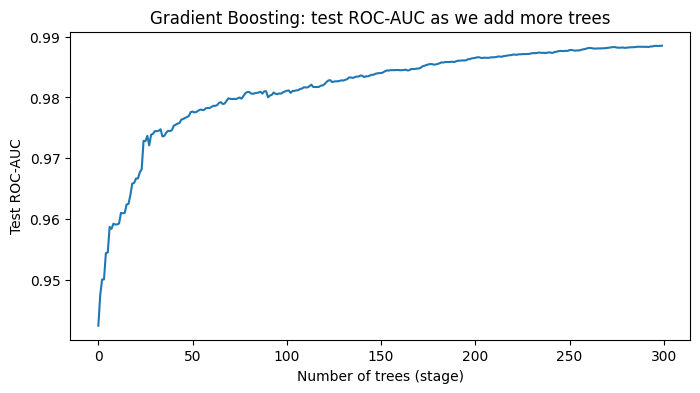

Best stage (1-indexed): 300
Best ROC-AUC: 0.9885101091660746


In [12]:

# How does test ROC-AUC change as we add more trees?
# "staged_predict_proba" gives predictions after 1 tree, 2 trees, 3 trees, ...

gb_model = gb.named_steps["model"]
X_test_trans = gb.named_steps["preprocess"].transform(X_test)

test_auc_by_stage = []
for proba_stage in gb_model.staged_predict_proba(X_test_trans):
    test_auc_by_stage.append(roc_auc_score(y_test, proba_stage[:, 1]))

plt.figure(figsize=(8, 4))
plt.plot(test_auc_by_stage)
plt.xlabel("Number of trees (stage)")
plt.ylabel("Test ROC-AUC")
plt.title("Gradient Boosting: test ROC-AUC as we add more trees")
plt.show()

print("Best stage (1-indexed):", int(np.argmax(test_auc_by_stage)) + 1)
print("Best ROC-AUC:", float(np.max(test_auc_by_stage)))



### A modern boosted tree model: HistGradientBoosting

`HistGradientBoostingClassifier` is faster on larger datasets.
It also supports **early stopping**.

Early stopping means:
- stop adding trees when validation performance stops improving

This is a simple way to reduce overfitting.


In [13]:

hgb = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", HistGradientBoostingClassifier(
        learning_rate=0.08,
        max_depth=3,
        max_iter=600,               # number of boosting iterations (trees)
        early_stopping=True,
        validation_fraction=0.15,
        random_state=42
    ))
])

hgb.fit(X_train, y_train)
evaluate(hgb, X_test, y_test)


{'accuracy': 0.96,
 'f1': 0.9553571428571429,
 'roc_auc': np.float64(0.990217847684258)}


### Boosting exercise (simple)

1. In the Gradient Boosting model, try:
   - `learning_rate=0.2` and `n_estimators=100`
   - `learning_rate=0.05` and `n_estimators=600`
2. Compare the results (accuracy, F1, ROC-AUC).
3. Which setting seems to work better here, and why?

*(Hint: small learning rate usually needs more trees.)*



---

# Stacking

## Big idea (simple words)

Stacking combines **different types** of models.

Instead of using a simple vote, stacking learns **how** to combine them.

It has two levels:
1. **Base models** (level-0): make predictions
2. **Meta-model** (level-1): learns from base predictions and makes the final prediction

### Important: avoid cheating (data leakage)

If the meta-model sees base predictions made on the **same data** used to train the base model,
it can learn unrealistically good patterns.

To avoid that, stacking usually uses **cross-validation** to create “out-of-fold” predictions for training the meta-model.
`StackingClassifier` in scikit-learn does this for us.



## 8) Stacking example: combine strong + different models

We will use these base models:
- Logistic Regression (linear)
- Random Forest (bagging-style, non-linear)
- KNN (local similarity)
- SVM (non-linear boundary)

Then we use Logistic Regression as the meta-model.


In [14]:

# Many base models need scaling; we already scale numeric features in preprocess.
# For tree-based models, scaling doesn't matter much, but it also doesn't hurt.

estimators = [
    ("lr", LogisticRegression(max_iter=2000)),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    )),
    ("knn", KNeighborsClassifier(n_neighbors=25)),
    ("svm", SVC(C=2.0, kernel="rbf", probability=True, random_state=42)),
]

stack = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(max_iter=2000),
        cv=5,
        stack_method="predict_proba",
        n_jobs=-1,
        passthrough=False
    ))
])

stack.fit(X_train, y_train)

stack_metrics = evaluate(stack, X_test, y_test)
stack_metrics


{'accuracy': 0.979,
 'f1': 0.9765886287625418,
 'roc_auc': np.float64(0.9950059750662102)}


### Compare stacking to a simple voting ensemble

A quick baseline for “combining different models” is **VotingClassifier**:
- hard voting: vote on class labels
- soft voting: average predicted probabilities

Voting does not learn *how* to combine models; stacking does.


In [15]:

voting = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", VotingClassifier(
        estimators=estimators,
        voting="soft",   # uses probabilities
        n_jobs=-1
    ))
])

voting.fit(X_train, y_train)

compare_stack = pd.DataFrame({
    "Voting (soft)": evaluate(voting, X_test, y_test),
    "Stacking": stack_metrics,
}).T

compare_stack


,accuracy,f1,roc_auc
Voting (soft),0.974,0.970982,0.993242
Stacking,0.979,0.976589,0.995006



## 9) Stacking with passthrough (optional)

If `passthrough=True`, the meta-model gets:
- base model predictions **and**
- the original features

This can sometimes improve results, but it can also overfit.


In [16]:

stack_passthrough = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(max_iter=2000),
        cv=5,
        stack_method="predict_proba",
        n_jobs=-1,
        passthrough=True
    ))
])

stack_passthrough.fit(X_train, y_train)
evaluate(stack_passthrough, X_test, y_test)


{'accuracy': 0.978,
 'f1': 0.9754464285714286,
 'roc_auc': np.float64(0.9959466442736258)}


### Stacking exercise (simple)

1. Add one more base model to the `estimators` list.
   - Example: a Gradient Boosting model (try `HistGradientBoostingClassifier`) or a smaller Random Forest.
2. Re-train stacking and compare test ROC-AUC.
3. Try `passthrough=True` and `passthrough=False`.
   - Which one works better on this dataset?

*(Write 2–4 sentences about what you learn.)*



---

# 10) Clean evaluation with cross-validation (recommended)

A single train/test split can be unlucky.
Cross-validation gives a more reliable estimate.

We will run 5-fold cross-validation for:
- baseline Logistic Regression
- bagging
- boosting (HistGradientBoosting)
- stacking


In [ ]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Baseline (LogReg)": baseline,
    "Bagging (trees)": bagging_trees,
    "Boosting (HistGB)": hgb,
    "Stacking": stack,
}

cv_results = []
for name, model in models.items():
    scores = cross_val_score(model, df, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    cv_results.append({
        "model": name,
        "mean ROC-AUC": scores.mean(),
        "std ROC-AUC": scores.std(),
    })

pd.DataFrame(cv_results).sort_values("mean ROC-AUC", ascending=False)



---

# 11) When to use which method (quick guide)

### Bagging
Use when:
- your base model is unstable / high-variance (e.g., deep decision trees)
- you want a reliable improvement with little tuning

Typical choices:
- Bagging with trees
- Random Forest (bagging + random feature selection)

### Boosting
Use when:
- you want very strong performance on structured data
- you are willing to tune a bit (`learning_rate`, `n_estimators`, tree size)
- you can handle the risk of overfitting (use early stopping)

Typical choices:
- Gradient Boosting
- HistGradientBoosting
- (Outside scikit-learn: XGBoost / LightGBM / CatBoost)

### Stacking
Use when:
- you already have a few good but different models
- you suspect they make different kinds of errors
- you want to squeeze extra performance

Typical choices:
- combine linear + tree-based + distance-based models
- use cross-validation inside stacking to avoid leakage



---

# Appendix (optional): the same ideas for regression

Ensembles also work for regression.
Below is a small example with structured numeric + categorical features.

If you only need classification, you can skip this section.


In [ ]:

from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Create a regression dataset
Xr_num, yr = make_regression(
    n_samples=3000, n_features=8, n_informative=6, noise=25.0, random_state=42
)
dfr = pd.DataFrame(Xr_num, columns=[f"num_{i}" for i in range(Xr_num.shape[1])])

# Add a categorical column
dfr["segment"] = pd.cut(
    dfr["num_0"],
    bins=[-np.inf, -0.5, 0.5, np.inf],
    labels=["A", "B", "C"]
).astype("object")

# Missing values
mask = rng.random(len(dfr)) < 0.02
dfr.loc[mask, "num_3"] = np.nan

Xr_train, Xr_test, yr_train, yr_test = train_test_split(dfr, yr, test_size=0.25, random_state=42)

cat_cols_r = ["segment"]
num_cols_r = [c for c in dfr.columns if c not in cat_cols_r]

preprocess_r = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num_cols_r),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                          ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]), cat_cols_r),
    ]
)

def eval_reg(pipe):
    pred = pipe.predict(Xr_test)
    return {
        "RMSE": mean_squared_error(yr_test, pred, squared=False),
        "R2": r2_score(yr_test, pred),
    }

ridge = Pipeline([("preprocess", preprocess_r), ("model", Ridge(alpha=1.0))])

bag_reg = Pipeline([
    ("preprocess", preprocess_r),
    ("model", BaggingRegressor(
        estimator=DecisionTreeRegressor(random_state=42),
        n_estimators=250,
        max_samples=0.8,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    ))
])

gbr = Pipeline([
    ("preprocess", preprocess_r),
    ("model", GradientBoostingRegressor(
        n_estimators=400,
        learning_rate=0.06,
        max_depth=2,
        random_state=42
    ))
])

stack_reg = Pipeline([
    ("preprocess", preprocess_r),
    ("model", StackingRegressor(
        estimators=[
            ("ridge", Ridge(alpha=1.0)),
            ("rf", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)),
            ("gbr", GradientBoostingRegressor(n_estimators=250, learning_rate=0.08, max_depth=2, random_state=42)),
        ],
        final_estimator=Ridge(alpha=1.0),
        cv=5,
        n_jobs=-1
    ))
])

for m in [ridge, bag_reg, gbr, stack_reg]:
    m.fit(Xr_train, yr_train)

pd.DataFrame({
    "Ridge (baseline)": eval_reg(ridge),
    "Bagging (trees)": eval_reg(bag_reg),
    "Boosting (GBR)": eval_reg(gbr),
    "Stacking": eval_reg(stack_reg),
}).T
